# packages for spatial analysis with: 
![python](./images/python.png) 
![anaconda](./images/anaconda.png)
[Download Anaconda](https://www.continuum.io/downloads)

* __large-scale data processing__
* __predictive analytics, and scientific computing__
* __simplify package management and deployment__
* __ installs into your home directory, i.e. no admin priveleges needed__ 

![git](./images/git.jpg)
[Download and install git](https://git-scm.com/downloads)

* __the most widely used modern version control system in the world today__
* __installs with vim on windows__
* __Code development and sharing__

### **To create a virtual environment, start with the following command:**

#  C:\\> conda create -n envName jupyter geopandas folium

### **get the git repository [here](https://github.com/debboutr/SDMG) and either clone or fork it!**

### **github can be a text editor as well!**

# <font color='green'> [LakeCat Dataset:](https://github.com/USEPA/LakeCat) QA  Methods</font>

The following code walk through the process of finding local lake basins with the on-network accumulation process. For each lake, we report the "catchment" statistics as a landscape summarization of the NHD Catchments associated by flowlines that hold the waterbodies COMID in the "WBAREACOMI" field. Using geopandas, we can do a unary_union with these catchments and compare the overlapping areas using the 'difference' method built in to geopandas. This script selects polys where we find less than 50% of the lake is covered by it's associated catchments and plots them with the folium package for a slippy map of each of the instances of poor coverage.

![LakeCat](./images/linked.png)

_**LakeCat** sumarizes landscape metrics for **NHDWaterBody** watersheds. In order to report an accurate local basin for each, an array of **NHDCatchments** are accumlated in cases where more than one needed to cover the waterbody polygon_

_**NHDFlowlines** hold WBAREACOMI attribute that links flowlines to lakes.  We map those to catchments and come up with the local_ 'catchment' _basin, described in the 'Cat' statistics in LakeCat. This is a hybridized version of what the individual catchment is, the basin needs to cover the geometry of the water feature that it is describing_

{'init': u'epsg:4269'}


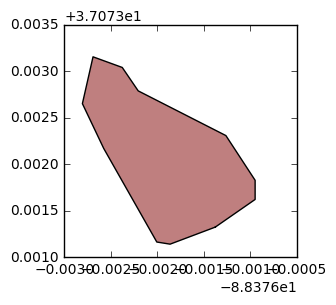

In [1]:
% matplotlib inline
import geopandas as gpd
lake = gpd.GeoDataFrame.from_file("./data/lake.shp")
print lake.crs  # GCS_North_American_1983
lake.plot(figsize=(3,3))

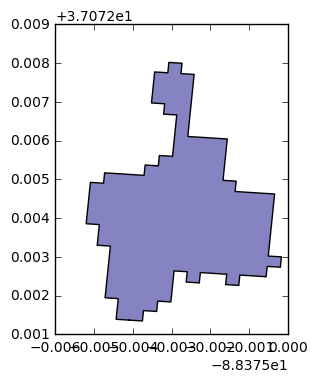

In [2]:
basin = gpd.GeoDataFrame.from_file("./data/basin.shp")
basin.plot(column='FEATUREID', cmap="plasma")

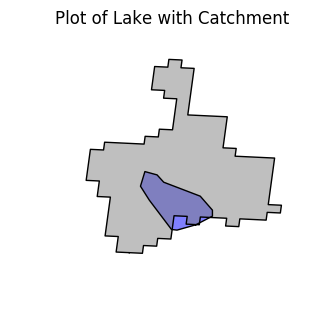

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(3,3))
base = lake.plot(ax=ax, color='blue')
basin.plot(ax=base, color='grey') 
ax.axis('off')
ax.set_title("Plot of Lake with Catchment")

### Access to attributes and statistics on fields

In [4]:
lakes = gpd.GeoDataFrame.from_file("./data/lakes.shp")
print 'AREASQKM : %s' % lakes.ix[lakes.COMID == 19742428].AREASQKM.values[0]  # find the attribute value of a single record
print 'Max: %s' % lakes.AREASQKM.max()
print 'Min: %s' %lakes.AREASQKM.min()
print 'Mean: %s' %lakes.AREASQKM.mean()
print 'Standard Deviation: %s' %lakes.AREASQKM.std()
lakes.head()

AREASQKM : 0.153
Max: 258.586
Min: 0.003
Mean: 2.95254965358
Standard Deviation: 19.1071153653


,AREASQKM,COMID,ELEVATION,FCODE,FDATE,FTYPE,GNIS_ID,GNIS_NAME,REACHCODE,RESOLUTION,SHAPE_AREA,SHAPE_LENG,VPU,geometry
0,0.056,22538778,0.0,43606,1999-06-17,Reservoir,None,None,None,Medium,0.000006,0.011360,06,POLYGON ((-82.20423298284258 36.96521067595594...
1,0.153,19742428,0.0,39004,1999-09-13,LakePond,992811,Price Lake,06010103001192,Medium,0.000015,0.021951,06,POLYGON ((-81.73179191690925 36.13824407723956...
2,0.014,19742448,0.0,39004,1999-09-13,LakePond,1017337,Inver Lochy Lake,06010103001195,Medium,0.000001,0.004810,06,POLYGON ((-81.83639331674688 36.12086041059987...
3,0.049,14638207,0.0,39004,1999-09-13,LakePond,None,None,06010205001811,Medium,0.000005,0.011417,06,"POLYGON ((-81.94507331657819 36.9739958759423,..."
4,0.010,14638213,0.0,39004,1999-09-13,LakePond,None,None,06010205001814,Medium,0.000001,0.004532,06,POLYGON ((-81.95456138323013 36.96109927596232...


### Similar approach using arcpy -- often leads to creating intermediate data or looping with a cursor
```
import arcpy
home = r"C:\Users\Rdebbout\Downloads\SpatialData"
shp = arcpy.MakeFeatureLayer_management("{}/NHDPlus16/NHDWaterbodies.shp".format(home))
fldList = arcpy.ListFields(shp)
for fld in fldList:
    print fld.name
rows = arcpy.SearchCursor(shp)
row = rows.next()
totalSize = 0
recordsCounted = 0 
while row:
    totalSize += row.getValue('AREASQKM')
    recordsCounted += 1
    row = rows.next()
average = totalSize / recordsCounted

arcpy.Statistics_analysis("NHDWaterbodies_Layer", "./outTable.dbf", [["AREASQKM","MEAN"]])
```

### FInd the difference of the 2 geometries using geopandas and shapely methods

0    1.961543e-07
dtype: float64


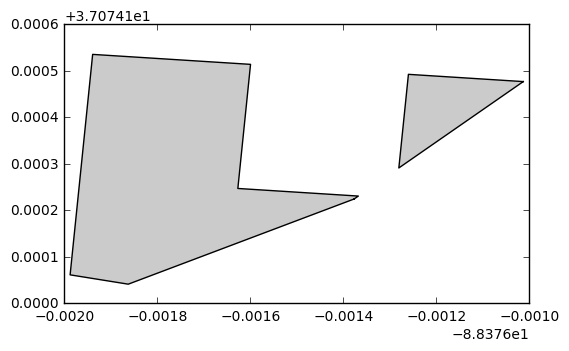

In [5]:
print lake['geometry'].difference(basin.unary_union.buffer(0)).area
lake['geometry'].difference(basin.unary_union.buffer(0)).plot()     

## <font color='orange'>The code below creates a leaflet map using folium</font>![folium](./images/folium.jpg)

In [ ]:
import pandas as pd
from StreamCat_functions import findUpstreamNpy, makeVPUdict
NHD_dir = 'D:/NHDPlusV21'
inputs = makeVPUdict(NHD_dir)
zone = '17'
hr = inputs[zone]
lakes = lksnet.ix[lksnet.VPU == zone]  
cats = gpd.GeoDataFrame.from_file('%s/NHDPlus%s/NHDPlus%s/NHDPlusCatchment/Catchment.shp' % (NHD_dir,hr, zone))   
lookup = pd.read_csv('D:/Projects/lakesAnalysis/On_Network_LakeCOMs/LakeCOMs%s.csv' % zone)
lks = gpd.GeoDataFrame()
bsn = gpd.GeoDataFrame()
miss = gpd.GeoDataFrame()
for zone in inputs:
    hr = inputs[zone]
    lakes = lksnet.ix[lksnet.VPU == zone]  
    cats = gpd.GeoDataFrame.from_file('%s/NHDPlus%s/NHDPlus%s/NHDPlusCatchment/Catchment.shp' % (NHD_dir,hr, zone))   
    lookup = pd.read_csv('D:/Projects/lakesAnalysis/On_Network_LakeCOMs/LakeCOMs%s.csv' % zone)
    for idx, row in lookup.iterrows():
        lake = lakes.ix[lakes.COMID == row.wbCOMID]
        catbas = findUpstreamNpy(zone, int(row.catCOMID), catnumps)
        basin = cats.ix[cats.FEATUREID.isin(catbas)]
        try: 
            diffgeom = lake['geometry'].difference(basin.unary_union.buffer(0))
            pct = diffgeom.area / lake.area * 100
            if pct.values[0] > 50:
                lks = pd.concat([lks, lake])
                bsn = pd.concat([bsn, basin])
                miss = pd.concat([miss, gpd.GeoDataFrame(data={'PCT': pct},geometry=diffgeom)])
        except:
            print row.wbCOMID
            continue

## Topology exception due to MultiPolyon -- collection of Polygons joined @ 1 point

![folium](./images/dangles.PNG)

In [ ]:
lks.to_crs({'init' :'epsg:4326'}).to_file(r"C:\Users\Rdebbout\Plot2Shps\lks.json",driver="GeoJSON")
bsn.to_crs({'init' :'epsg:4326'}).to_file(r"C:\Users\Rdebbout\Plot2Shps\bsn.json",driver="GeoJSON")
miss.to_crs({'init' :'epsg:4326'}).to_file(r"C:\Users\Rdebbout\Plot2Shps\miss.json",driver="GeoJSON")

In [ ]:
center_point = lakes.unary_union.buffer(0).centroid
print center_point.x
print center_point.y

In [ ]:
import folium
map=folium.Map(location=[45.96040854768601, -117.47340297823],zoom_start=6,tiles="Stamen Terrain")
fg=folium.FeatureGroup(name="Lake Points")
for lat,lon,name in zip(lks['geometry'].centroid.map(lambda p: p.y),lks['geometry'].centroid.map(lambda p: p.x),lks['COMID']):
        fg.add_child(folium.Marker(location=[lat,lon],popup=name.map(lambda x: "NHD Waterbody COMID: %s" % x),
                                   icon=folium.Icon(icon_color='black')))
map.add_child(fg)
map.add_child(folium.GeoJson(data=open(r'C:\Users\Rdebbout\Plot2Shps\lks.json'),
                name='NHD Lake',
                style_function=lambda x: {'fillColor':'blue', 'fill_opacity': 0.2, 'color':'black'}))
map.add_child(folium.GeoJson(data=open(r'C:\Users\Rdebbout\Plot2Shps\bsn.json'),
                name='Catchment Basin',
                style_function=lambda x: {'fillColor':'grey', 
                          'fill_opacity': 0.47,}))
map.add_child(folium.GeoJson(data=open(r'C:\Users\Rdebbout\Plot2Shps\miss.json'),
                name='Missed Area',
                style_function=lambda x: {'fillColor':'red', 'fill_opacity': 0.2, 'color':'none'}))
map.add_child(folium.LayerControl())
map.save(outfile=r'C:\Users\Rdebbout\Plot2Shps\lakesPoint.html')

In [ ]:
for lat,lon,name in zip(lks['geometry'].centroid.map(lambda p: p.y),lks['geometry'].centroid.map(lambda p: p.x),lks['COMID']):
    print "Lat: {} \nLon: {} \nCOMID: {}".format(lat,lon,name)

In [8]:
import pandas as pd
pd.DataFrame?

In [ ]:
% timeit
lks2.to_crs({'init' :'epsg:4326'}).to_file(r"C:\Users\Rdebbout\Plot2Shps\lks3.json",driver="GeoJSON")
bsn2.to_crs({'init' :'epsg:4326'}).to_file(r"C:\Users\Rdebbout\Plot2Shps\bsn3.json",driver="GeoJSON")
miss2.to_crs({'init' :'epsg:4326'}).to_file(r"C:\Users\Rdebbout\Plot2Shps\miss3.json",driver="GeoJSON")

In [ ]:
map=folium.Map(location=[45.96040854768601, -117.47340297823],zoom_start=6,tiles="Stamen Terrain")

fg=folium.FeatureGroup(name="Lake Points")
for lat,lon,name in zip(lakes['geometry'].centroid.map(lambda p: p.y),lakes['geometry'].centroid.map(lambda p: p.x),lakes['COMID']):
        fg.add_child(folium.Marker(location=[lat,lon],popup='NHD Waterbody COMID: %s' % name,
                                   icon=folium.Icon(icon_color='white', prefix='fa',icon='warning')))
map.add_child(fg)

map.add_child(folium.GeoJson(data=open(r'C:\Users\Rdebbout\Plot2Shps\lks.json'),
name='NHD Lake',
style_function=lambda x: {'fillColor':'blue', 'fill_opacity': 0.4, 'color':'#5bc0de'}
))
map.add_child(folium.GeoJson(data=open(r'C:\Users\Rdebbout\Plot2Shps\bsn.json'),
name='Catchment Basin',
style_function=lambda x: {'fillColor':'grey', 
                          'fill_opacity': 0.3, 
                          'color':'white'}
))
map.add_child(folium.GeoJson(data=open(r'C:\Users\Rdebbout\Plot2Shps\miss.json'),
name='Missed Area',
style_function=lambda x: {'fillColor':'red', 'fill_opacity': 0.2, 'color':'none'}
))
map.add_child(folium.LayerControl())
map.save(outfile=r'C:\Users\Rdebbout\Plot2Shps\lakesPoint.html')

In [ ]:
def color(vpu):
    if vpu in ['09','16','08','03N']:
        col='#d9534f'
    elif vpu in ['10U','05','13','03S']:
        col='#f9f9f9'
    elif vpu in ['14','07','02','12']:
        col='#5bc0de'
    elif vpu in ['17','10L','04','06','15']:
        col='#5cb85c'
    elif vpu in ['18','11','01','03W']:
        col='#428bca'
    return col

In [ ]:
extent = lks2.unary_union.bounds
lat_Center = (extent[1] + extent[3]) / 2
lon_Center = (extent[0] + extent[2]) / 2

In [ ]:
http://fontawesome.io/icons/
http://glyphicons.bootstrapcheatsheets.com/

In [ ]:
#import os
import numpy as np
#import sys
import geopandas as gpd
#sys.path.append('/home/rick/projects/SDMG')
from StreamCat_functions import findUpstreamNpy

numpy_dir = '/media/rick/600ABCCF0ABCA386/Users/rick/Documents/SDMG_Lakes/On_Net_Npy_files/children'
zone = '03W'
comids = np.load(numpy_dir + '/comids' + zone + '.npy')

lakes = gpd.GeoDataFrame.from_file('/media/rick/gitSum/NHDv21/NHDPlusSA/NHDPlus03W/NHDSnapshot/Hydrography/NHDWaterbody.shp')
